In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import yfinance as yf  # !pip install yfinance
import quandl          # !pip install quandl
quandl.ApiConfig.api_key = ''
# !pip install python-coinmarketcap

In [366]:
today = datetime.datetime.now().strftime('%Y-%m-%d')

# Getting Stock data

In [511]:
def get_yahoo(tickers,beg,end):
    df = yf.download(tickers,beg,end)['Adj Close'][tickers]
    df.index.name = 'date'
    return df
get_yahoo(['AAPL','FZROX'],'2016-01-01',today).head()

[*********************100%***********************]  2 of 2 downloaded


,AAPL,FZROX
date,,
2016-01-04,98.74,NaN
2016-01-05,96.27,NaN
2016-01-06,94.38,NaN
2016-01-07,90.40,NaN
2016-01-08,90.88,NaN


In [23]:
data = quandl.get("WIKI/AAPL", start_date="2016-01-01", end_date="2018-01-01")
data.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2016-01-04,102.61,105.368,102.00,105.35,67649387.0,0.0,1.0,99.136516,101.801154,98.547165,101.783763,67649387.0
2016-01-05,105.75,105.850,102.41,102.71,55790992.0,0.0,1.0,102.170223,102.266838,98.943286,99.233131,55790992.0
2016-01-06,100.56,102.370,99.87,100.70,68457388.0,0.0,1.0,97.155911,98.904640,96.489269,97.291172,68457388.0
2016-01-07,98.68,100.130,96.43,96.45,81094428.0,0.0,1.0,95.339552,96.740467,93.165717,93.185040,81094428.0
2016-01-08,98.55,99.110,96.76,96.96,70798016.0,0.0,1.0,95.213952,95.754996,93.484546,93.677776,70798016.0


In [374]:
def get_quandl(tickers,beg,end):
    return quandl.get_table('WIKI/PRICES', ticker = stocks,
                            qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                            date = { 'gte': beg, 'lte': end }, paginate=True)\
           .set_index('date').pivot(columns='ticker')['adj_close']
get_quandl(['AAPL','AMZN','GOOGL','FB'],'2010-01-01',today).head()

ticker,AAPL,AMZN,FB,GOOGL
date,,,,
2010-01-04,27.503268,133.90,NaN,314.345354
2010-01-05,27.550818,134.69,NaN,312.961081
2010-01-06,27.112585,132.25,NaN,305.071727
2010-01-07,27.062465,130.00,NaN,297.969804
2010-01-08,27.242385,133.52,NaN,301.942066


In [568]:
def get_coinbase(tickers,beg,end):
    import requests,json,time,datetime
    begdt = datetime.datetime.strptime(beg,'%Y-%m-%d')
    df = pd.DataFrame()
    for tkr in tickers:
        session = requests.Session()
        results = []
        for sh in range(0,3000,300):
            time.sleep(1.1/3)
            beg_ = (begdt + datetime.timedelta(days=sh)).strftime('%Y-%m-%d')
            if beg_>end: break
            end_ = (begdt + datetime.timedelta(days=sh+299)).strftime('%Y-%m-%d')
            if end_>end: end_=end
            request = session.get(url=f'https://api.pro.coinbase.com/products/{tkr}-USD/candles?start={beg_}&end={end_}&granularity=86400')
            results += json.loads(request.text)
        if results:
            data = pd.DataFrame(results)
            data[0] = data[0].apply(lambda i: datetime.datetime.utcfromtimestamp(i).strftime('%Y-%m-%d'))
            df[tkr] = data.set_index(0)[4]
    df.index.name='date'
    return df.sort_index()
get_coinbase(['BTC','LINK','ETH'],'2018-01-01','2018-12-31').head()

,BTC,ETH
date,,
2018-01-01,13480.01,759.03
2018-01-02,14781.51,865.00
2018-01-03,15098.14,938.31
2018-01-04,15144.99,949.00
2018-01-05,16960.01,969.27


# Efficient Frontier

In [ ]:
# tickers = ['FZROX','FXNAX','FSRNX','FZILX']
# tickers = ['VTSAX','VBTLX','VGSLX','VTIAX']
tickers = ['VTI','BND','VNQ']
data1 = get_yahoo(tickers, '2018-01-01', today).dropna()
data1.head()

In [ ]:
tickers=['BTC','ETH']
data2 = get_coinbase(tickers, '2018-01-01', today).dropna()
data2.head()

In [579]:
data = pd.merge(data1,data2,left_index=True,right_index=True,how='inner')
tickers = data.columns.tolist()
data.head()

,VTI,BND,VNQ,BTC,ETH
date,,,,,
2018-01-02,134.40,77.77,77.75,14781.51,865.00
2018-01-03,135.18,77.84,77.52,15098.14,938.31
2018-01-04,135.70,77.80,76.19,15144.99,949.00
2018-01-05,136.49,77.69,76.22,16960.01,969.27
2018-01-08,136.80,77.70,76.62,14993.74,1137.01


In [581]:
returns = np.log(data/data.shift()) # data.pct_change()
mean = returns.mean()
cov = returns.cov()
rf = 0.015
N = int(1e5)
annual = 252
print('bare ret & risk:',mean.values*annual,np.sqrt(np.diag(cov*annual)))

bare ret & risk: [ 0.0623334   0.05430135  0.10289707 -0.26131249 -0.98653021] [0.15759791 0.0285095  0.14903208 0.78315162 0.9977047 ]


In [582]:
pweights = np.random.random((len(tickers),N)) # no short; no cash
pweights = pweights/pweights.sum(0)
pret = pweights.T.dot(mean) * annual
prisk = np.sqrt(np.array([w.T.dot(cov).dot(w) for w in pweights.T])*annual)  # equiv: returns.dot(pweights).std()*np.sqrt(annual)
# prisk = returns.dot(pweights).sub(rf/annual).clip(None,0).pow(2).mean().pow(.5)*np.sqrt(annual) # Sortino
psharpe = (pret - rf) / prisk

In [583]:
maxsharpe = max(zip(pweights.T,pret,prisk,psharpe),key=lambda e:e[3])
minvolati = min(zip(pweights.T,pret,prisk,psharpe),key=lambda e:e[2])
maxreturn = max(zip(pweights.T,pret,prisk,psharpe),key=lambda e:e[2]<0.7 and e[1])
print(f'max sharpe: weights {maxsharpe[0]}; return {maxsharpe[1]:.5f}; risk {maxsharpe[2]:.5f}; sharpe {maxsharpe[3]:.5f}')
print(f'min vol   : weights {minvolati[0]}; return {minvolati[1]:.5f}; risk {minvolati[2]:.5f}; sharpe {minvolati[3]:.5f}')
print(f'max return: weights {maxreturn[0]}; return {maxreturn[1]:.5f}; risk {maxreturn[2]:.5f}; sharpe {maxreturn[3]:.5f}')

max sharpe: weights [0.0381704  0.62563035 0.32488464 0.00985705 0.00145756]; return 0.06577; risk 0.05656; sharpe 0.89767
min vol   : weights [0.12013118 0.73101407 0.12726729 0.01165624 0.00993123]; return 0.04744; risk 0.04124; sharpe 0.78644
max return: weights [0.11303033 0.17102166 0.70252726 0.00833069 0.00509006]; return 0.08142; risk 0.11568; sharpe 0.57418


<IPython.core.display.Javascript object>


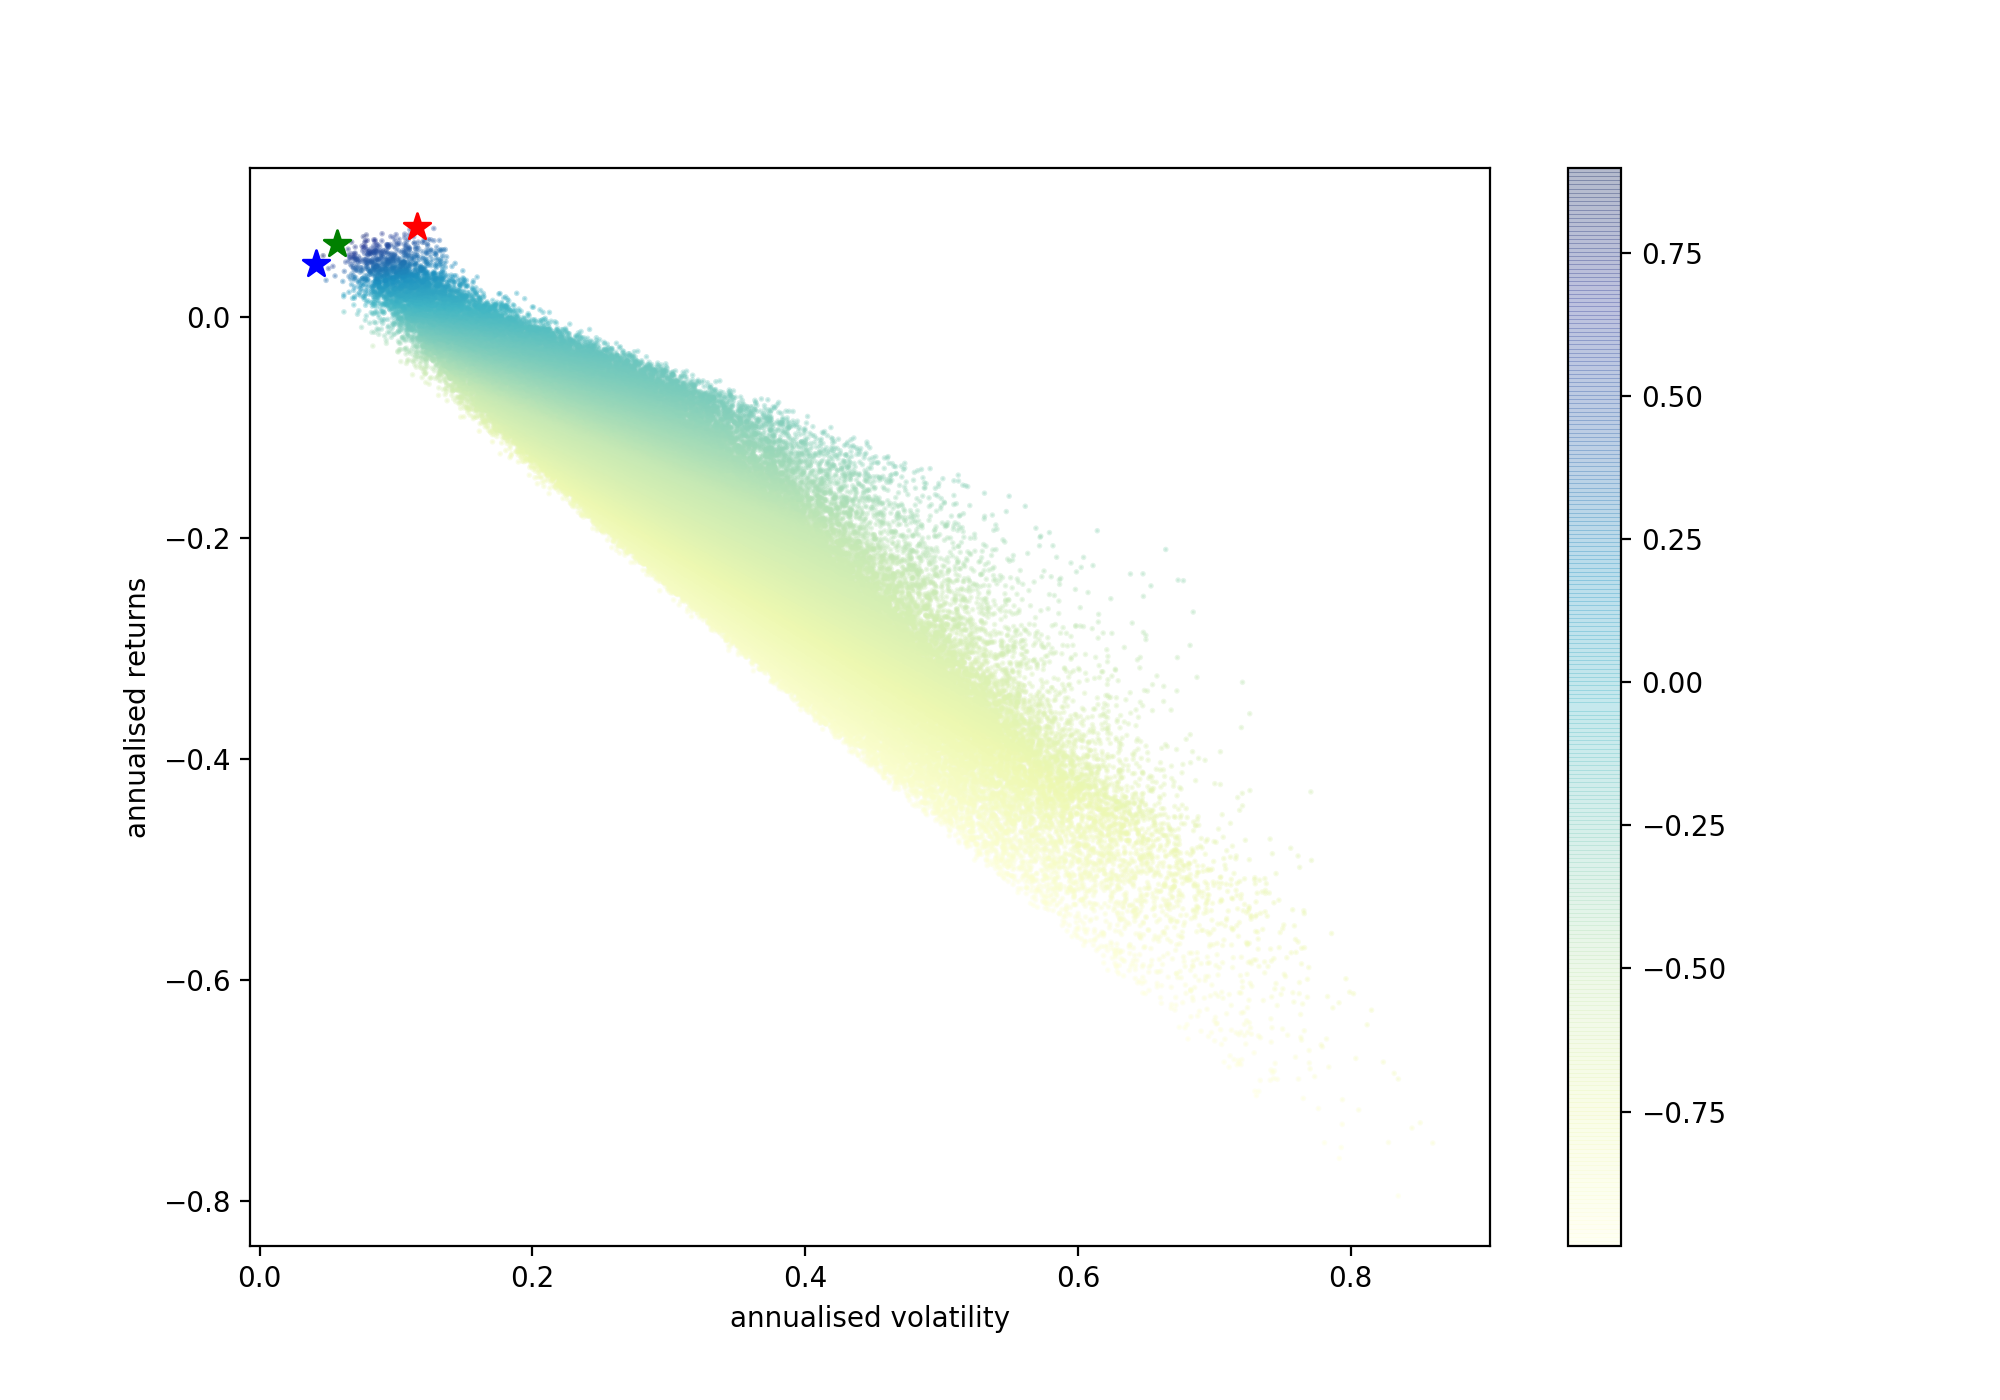

In [584]:
%matplotlib notebook
plt.figure(figsize=(10, 7))
plt.scatter(prisk,pret,c=psharpe,cmap='YlGnBu', marker='o', s=1, alpha=0.3)
plt.colorbar()
plt.scatter(maxsharpe[2],maxsharpe[1],marker='*',color='g',s=100, label='Maximum Sharpe ratio')
plt.scatter(minvolati[2],minvolati[1],marker='*',color='b',s=100, label='Minimum volatility')
plt.scatter(maxreturn[2],maxreturn[1],marker='*',color='r',s=100, label='Maximum return')
plt.xlabel('annualised volatility')
plt.ylabel('annualised returns')
plt.show()